<a href="https://colab.research.google.com/github/RyuKyungchan/UGRP/blob/main/MLP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neurodsp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.1 MB/s eta 0:00:00


In [2]:
# Import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Import sim functions
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series


In [3]:
# Set some general settings, to be used across all simulations
num_signals = 1000
fs = 2000 #sampling 주파수
n_seconds = 2 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

# Define the components of the combined signal to simulate
n_neurons_range = (800, 1200)  # range for number of neurons
firing_rate_range = (2, 4)     # range for firing rate
t_ker_range = (0.8, 1.2)       # range for t_ker
tau_r_range = (0.001, 0.003)   # range for tau_r
tau_d_range = (0.015, 0.025)   # range for tau_d
freq_range = (15, 25)          # range for oscillation frequency
amplitude_range = (5,6)   # range for amplitude_range

# Sample values from the specified ranges
n_neurons = np.random.randint(n_neurons_range[0], n_neurons_range[1] + 1)
firing_rate = np.random.uniform(firing_rate_range[0], firing_rate_range[1])
t_ker = np.random.uniform(t_ker_range[0], t_ker_range[1])
tau_r = np.random.uniform(tau_r_range[0], tau_r_range[1])
tau_d = np.random.uniform(tau_d_range[0], tau_d_range[1])
freq = np.random.uniform(freq_range[0], freq_range[1])


In [4]:
# 초기 (0, 4000) 크기의 빈 numpy 배열 생성
data_signal = np.empty((0, len(times)))
data_signal_with_sine = np.empty((0, len(times)))
data_sine_wave = np.empty((0, len(times)))

In [5]:
for idx in range(num_signals):
    components = {
        'sim_synaptic_current': {
        'n_neurons': n_neurons,
        'firing_rate': firing_rate,
        't_ker': t_ker,
        'tau_r': tau_r,
        'tau_d': tau_d
        },
        'sim_oscillation': {
        'freq': freq
        }
    }
    # Simulate an oscillation over an aperiodic component
    signal = sim_combined(n_seconds, fs, components)

    # Generate a 130 Hz sine wave
    amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
    t = np.arange(0, n_seconds, 1/fs)
    sine_wave = amplitude * np.sin(2 * np.pi * 130 * t)

    # Add the sine wave to the simulated signal
    signal_with_sine = signal + sine_wave

    # Add the signal as a new raw in the numpy array
    data_signal = np.vstack((data_signal, signal))
    data_signal_with_sine = np.vstack((data_signal_with_sine, signal_with_sine))
    data_sine_wave = np.vstack((data_sine_wave, sine_wave))

# data_signal의 shape 확인
print(data_signal.shape)
print(data_signal_with_sine.shape)
print(data_sine_wave.shape)

(1000, 4000)
(1000, 4000)
(1000, 4000)


In [ ]:
# MLP

In [6]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
X = data_signal_with_sine
y = data_signal

# data_signal의 shape 확인
print(data_signal.shape)
print(data_signal_with_sine.shape)
print(data_sine_wave.shape)

(1000, 4000)
(1000, 4000)
(1000, 4000)


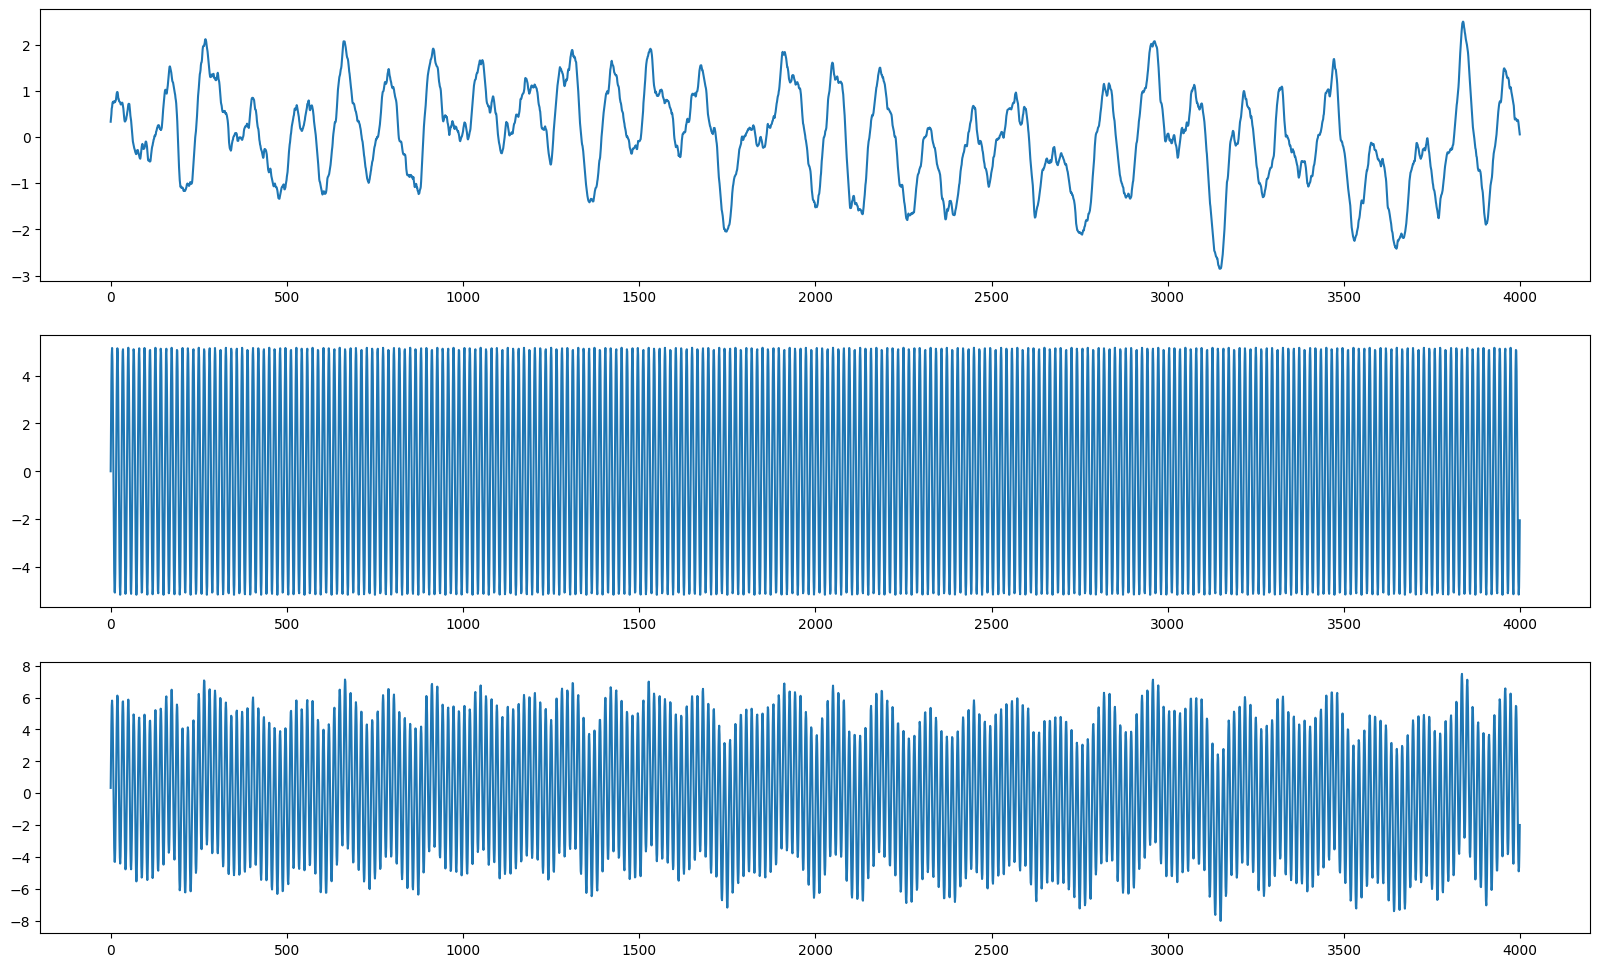

In [9]:
# example for loading data
plt.figure(figsize=(20,12))
plt.subplot(3, 1, 1)
plt.plot(data_signal[0, :])
plt.subplot(3, 1, 2)
plt.plot(data_sine_wave[0, :])
plt.subplot(3, 1, 3)
plt.plot(data_signal_with_sine[0, :])
plt.show()

In [10]:
# train/test 데이터셋 분리 (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_test1 = y_test

# numpy array를 tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# StandardScaler를 사용하여 데이터 스케일링
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(X_train)
x_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 차원 추가
x_train_scaled = x_train_scaled.reshape((700, 4000, 1))

# 데이터셋 크기 확인
print(f"x_train_scaled shape: {x_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

# TensorDataset을 사용하여 데이터셋 생성
train_dataset = TensorDataset(torch.tensor(x_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)



x_train_scaled shape: (700, 4000, 1)
y_train_scaled shape: (700, 4000)


In [13]:
# DNN 모델 정의
class BrainSignalDNN(nn.Module):
    def __init__(self):
        super(BrainSignalDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=x_train_scaled.shape[2], out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)

    def forward(self, input_data):
        #print("input shape: ", input_data.shape)
        x = F.relu(self.fc1(input_data))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x).squeeze(-1)
        print("output shape: ", x.shape)
        return x

# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = BrainSignalDNN().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)


BrainSignalDNN(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [17]:
# 모델 학습
num_epochs = 1000
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)

        train = features.view(features.shape[0], 4000, 1)
        print(train.shape)

        # Forward pass
        outputs = model(train)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    loss_list.append(loss.item())
    iteration_list.append(epoch+1)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([28, 4000, 1])
output shape:  torch.Size([28, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torch.Size([32, 4000, 1])
output shape:  torch.Size([32, 4000])
torc

output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([32, 4000])
output shape:  torch.Size([12, 4000])
y_test shape (300, 4000)
Mean Squared Error: 0.15553985783799557
Mean Squared Error: 0.0397019162774086


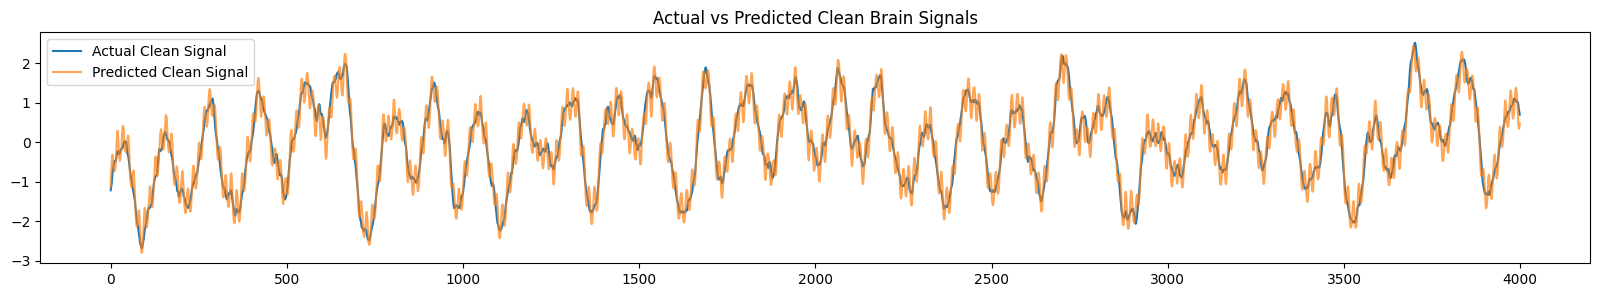

In [25]:
# 모델 평가
model.eval()
with torch.no_grad():
    y_pred_list = []
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        features = features.view(features.shape[0], 4000, 1)
        outputs = model(features)
        y_pred_list.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred_list, axis=0)
y_pred = scaler_y.inverse_transform(y_pred)

# y_test = y_test.numpy()
# y_test = scaler_y.inverse_transform(y_test_scaled)

y_test = y_test1
print("y_test shape", y_test.shape)

mse_loss = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse_loss}")

criterion = nn.MSELoss()
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
mse_loss = criterion(y_test_tensor, y_pred_tensor)
print(f"Mean Squared Error: {mse_loss.item()}")

# 결과 시각화
plt.figure(figsize=(20,3))
slice_size = 5
plt.plot(y_test[0], label='Actual Clean Signal')
plt.plot(y_pred[0], label='Predicted Clean Signal', alpha=0.7)

plt.legend()
plt.title('Actual vs Predicted Clean Brain Signals')
plt.show()